# Imbalanced Multilabel Scene Classification using Keras
- https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b

## Importing Necessary Libraries

In [3]:
# !pip install tensorflow

In [6]:
# !pip install imageio

In [20]:
# !pip install scipy
# !pip install scikit-learn
# !pip install seaborn
# !pip install scikit-image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import shutil, os, time, random, copy
import imageio
import h5py
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
from skimage.transform import rotate, AffineTransform, warp, resize
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

2022-12-26 17:02:42.037276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 17:02:42.560227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-26 17:02:42.560258: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-26 17:02:44.101517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Data Download and Extraction

In [2]:
# !wget http://www.lamda.nju.edu.cn/files/miml-image-data.rar
# !unrar e ./data/miml-image-data.rar
# !mkdir ./data/original_images
# !unrar e original.rar ./data/original_images
# !unrar e processed.rar ./data

## Data Processing

['desert', 'mountains', 'sea', 'sunset', 'trees']


<AxesSubplot: >

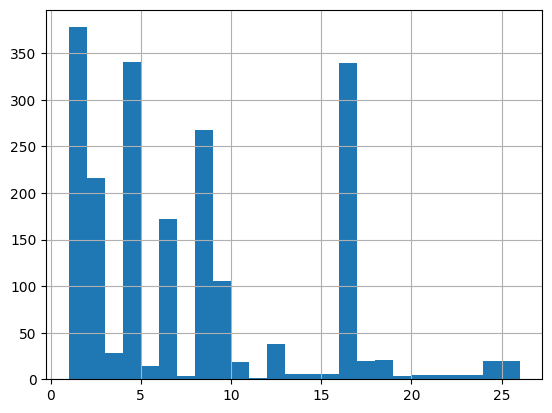

In [3]:
proc_mat = loadmat("./data/miml data.mat")

class_names = []
for c in proc_mat['class_name']:
    class_names.append(c[0][0])

print(class_names)
#output : ['desert', 'mountains', 'sea', 'sunset', 'trees']

labels = copy.deepcopy(proc_mat['targets'].T)
labels[labels==-1] = 0

data_df = pd.DataFrame(columns=["filenames"]+class_names)
filenames = os.listdir("./data/original_images/")
data_df["filenames"] = np.array(sorted(list(map(lambda x:int(x[:-4]),np.array(filenames)))))
data_df['filenames'] = data_df['filenames'].apply(lambda x:'./data/original_images/'+str(x)+'.jpg')
data_df[class_names] = np.array(labels)

#Applying Label Powerset Tranformation
data_df['powerlabel'] = data_df.apply(lambda x : 16*x["desert"]+8*x['mountains']+4*x['sea']+2*x['sunset']+1*x['trees'],axis=1)

data_df['powerlabel'].hist(bins=np.unique(data_df['powerlabel']))

In [4]:
data_df.sum()

filenames     ./data/original_images/1.jpg./data/original_im...
desert                                                      409
mountains                                                   458
sea                                                         580
sunset                                                      465
trees                                                       560
powerlabel                                                14018
dtype: object

## Histogram for each individual label

<BarContainer object of 2 artists>

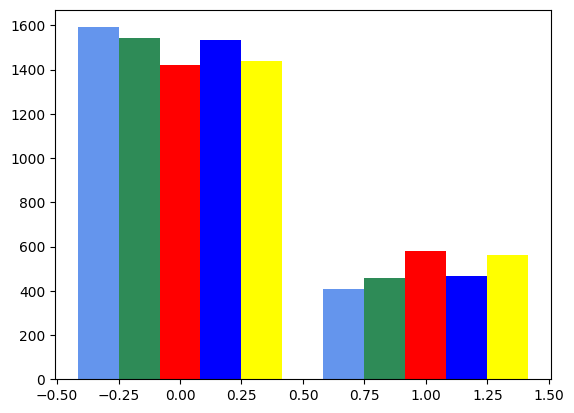

In [5]:
fig, ax = plt.subplots()

d_heights, d_bins = np.histogram(data_df['desert'],bins=[-0.5,0.5,1.5])
m_heights, m_bins = np.histogram(data_df['mountains'], bins=d_bins)
s_heights, s_bins = np.histogram(data_df['sea'], bins=m_bins)
ss_heights, ss_bins = np.histogram(data_df['sunset'], bins=s_bins)
t_heights, t_bins = np.histogram(data_df['trees'], bins=ss_bins)


width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor='cornflowerblue')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor='seagreen')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor='red')
ax.bar(ss_bins[:-1]+width*4, ss_heights, width=width, facecolor='blue')
ax.bar(t_bins[:-1]+width*5, t_heights, width=width, facecolor='yellow')

## Data Splitting

In [6]:
train_df = pd.DataFrame(columns = ["filenames"]+class_names)
val_df = pd.DataFrame(columns = ["filenames"]+class_names)
train_inds, val_inds = train_test_split(np.array(list(range(data_df.shape[0]))),test_size=0.2,random_state=7)
train_df = data_df.iloc[train_inds,:].reset_index(drop=True)
val_df = data_df.iloc[val_inds,:].reset_index(drop=True)

## Oversampling

In [7]:
powercount = {}
powerlabels = np.unique(train_df['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(train_df['powerlabel']==p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    #print(gapnum)
    temp_df = train_df.iloc[np.random.choice(np.where(train_df['powerlabel']==p)[0],size=gapnum)]
    data_df = train_df.append(temp_df,ignore_index=True)
    
train_df = train_df.sample(frac=1).reset_index(drop=True)

/tmp/ipykernel_514/2353630073.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = train_df.append(temp_df,ignore_index=True)


In [8]:
train_df.sum()

filenames     ./data/original_images/468.jpg./data/original_...
desert                                                      316
mountains                                                   369
sea                                                         468
sunset                                                      374
trees                                                       436
powerlabel                                                11064
dtype: object

## Calculating Class weights

In [9]:
positive_weights = {}
negative_weights = {}
for c in class_names:
    positive_weights[c] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==1))
    negative_weights[c] = train_df.shape[0]/(2*np.count_nonzero(train_df[c]==0))
print(positive_weights)
print(negative_weights)


{'desert': 2.5316455696202533, 'mountains': 2.168021680216802, 'sea': 1.7094017094017093, 'sunset': 2.1390374331550803, 'trees': 1.834862385321101}
{'desert': 0.6230529595015576, 'mountains': 0.6498781478472786, 'sea': 0.7067137809187279, 'sunset': 0.6525285481239804, 'trees': 0.6872852233676976}


In [10]:
img = imageio.imread('./data/original_images/1.jpg')
H,W,_ = img.shape
print(H,W)

476 582


/tmp/ipykernel_514/2130214254.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('./data/original_images/1.jpg')


## Data Generator

In [11]:
class DataGeneratorKeras(Sequence):
    # Constructor
    def __init__(self,train = True, augmentation = False, preprocessing_fn = None, batch_size = 16):
        self.train = train
        self.batch_size = batch_size
        self.directory="/content/original_images"
        self.H = H
        self.W = W

        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn

        if self.train:
            self.all_files = train_df
        else:
            self.all_files = val_df
    
    def __len__(self):
        return self.all_files.shape[0]//self.batch_size
    
    def on_epoch_end(self):
        self.all_files = self.all_files.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self, idx):
        images = np.array([],dtype=np.float32).reshape((0,self.H,self.W,3))
        labels = np.array([],dtype=np.float32).reshape((0,5))
        for i in range(self.batch_size):
            image = img_to_array(load_img(self.all_files['filenames'][idx*self.batch_size+i],target_size = (self.H,self.W)))
            y = self.all_files.iloc[idx*self.batch_size+i][class_names].values.astype(np.float32)
      
            # If there is any transform method, apply it onto the image
            if self.augmentation:
                image = rotate(image,np.random.uniform(-30,30),preserve_range=True)
                scale = np.random.uniform(1.0,1.25)
                tx = np.random.uniform(0,20)
                ty = np.random.uniform(0,20)
                image = warp(image,
                             AffineTransform(matrix=np.array([[scale, 0, tx],
                                                              [0,scale,  ty],
                                                              [0,   0,   1]])).inverse,
                             preserve_range=True)
            #RANDOM HORIZONTAL FLIPPING
            if np.random.choice([True,False]):
                image = np.flip(image,axis= 1)
            images = np.append(images,np.expand_dims(image,axis=0),axis=0)
            labels = np.append(labels,y.reshape(1,5),axis=0)
        
        if self.preprocessing_fn:
            images = self.preprocessing_fn(images)
        
        return images, labels

## Checking the data

In [12]:
tdg = DataGeneratorKeras(True,True,preprocess_input,16)

In [13]:
# tdg.__getitem__(0)

## Creating the train and validation data generators

In [14]:
train_datagen = DataGeneratorKeras(train = True, augmentation = True, preprocessing_fn = preprocess_input, batch_size = 16)
valid_datagen = DataGeneratorKeras(train = False, augmentation = False, preprocessing_fn = preprocess_input, batch_size = 16)

## Creating the Model

In [15]:
NUM_CLASSES = 5
fine_tuning = True

model = Sequential()

model.add(ResNet50(include_top=False,pooling='avg',weights='imagenet',input_shape=(H,W,3)))
model.add(Dense(NUM_CLASSES,activation = 'sigmoid'))

if fine_tuning:
    model.layers[0].trainable = True
else:
    model.layers[0].trainable = False

2022-12-26 17:02:46.810315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-26 17:02:46.810788: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-26 17:02:46.810871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-P01DK8R): /proc/driver/nvidia/version does not exist
2022-12-26 17:02:46.812407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


## Custom Loss Function for imbalanced classes

In [17]:
def loss_fn(y_true,y_pred):
    loss = 0
    loss -= (positive_weights['desert']*y_true[0]*K.log(y_pred[0]) + negative_weights['desert']*(1-y_true[0])*K.log(1-y_pred[0]))
    loss -= (positive_weights['mountains']*y_true[1]*K.log(y_pred[1]) + negative_weights['mountains']*(1-y_true[1])*K.log(1-y_pred[1]))
    loss -= (positive_weights['sea']*y_true[2]*K.log(y_pred[2]) + negative_weights['sea']*(1-y_true[2])*K.log(1-y_pred[2]))
    loss -= (positive_weights['sunset']*y_true[3]*K.log(y_pred[3]) + negative_weights['sunset']*(1-y_true[3])*K.log(1-y_pred[3]))
    loss -= (positive_weights['trees']*y_true[4]*K.log(y_pred[4]) + negative_weights['trees']*(1-y_true[4])*K.log(1-y_pred[4]))

    return loss

## Compile Model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.00001), 
              loss = loss_fn,
              metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
history = model.fit(train_datagen, epochs = 10, verbose = 1, validation_data = valid_datagen, shuffle = True)

Epoch 1/10
 68/100 [===================>..........] - ETA: 10:03 - loss: 3.1039 - binary_accuracy: 0.6697 - auc: 0.7159